### This notebook explores publicly available 2023 elevator outage data from the MTA.

#### The aim of this regression is to find if there are any variables that can explain why or where elevator outages occur

#### Loading packages:

In [2]:
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

%matplotlib inline  
from matplotlib import rcParams
rcParams['figure.figsize'] = (16, 100)

import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore") # Ignore all warnings
# warnings.filterwarnings("ignore", category=RRuntimeWarning) # Show some warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

In [3]:
%%javascript
// Disable auto-scrolling
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [4]:
%%R

# My commonly used R imports

require('tidyverse')

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Loading required package: tidyverse


#### Importing elevator data with census variables.
Here, each row is an elevator

In [5]:
%%R
#read csv file
df <- read.csv("data/regression/elevator_final.csv")

In [6]:
%%R
#show me the names of the columns in the dataframe
names(df)

 [1] "GEOID"                          "Common.Name"                   
 [3] "Equipment.Description"          "Station.ID"                    
 [5] "Complex.ID"                     "GTFS.Stop.ID"                  
 [7] "Division"                       "Line"                          
 [9] "Stop.Name"                      "Borough_x"                     
[11] "Daytime.Routes"                 "Structure"                     
[13] "lat"                            "long"                          


[15] "North.Direction.Label"          "South.Direction.Label"         
[17] "ADA"                            "Georeference"                  
[19] "STATE"                          "COUNTY"                        
[21] "TRACT"                          "BLOCK"                         
[23] "NAME"                           "geometry"                      
[25] "population_estimate"            "sub_pop_estimate"              
[27] "amb_pop_estimate"               "med_earn_estimate"             
[29] "population_moe"                 "sub_pop_moe"                   
[31] "amb_pop_moe"                    "med_earn_moe"                  
[33] "outage_count"                   "Borough_y"                     
[35] "Equipment.Type"                 "Time.Since.Major.Improvement_y"
[37] "AM.Peak.Availability"           "AM.Peak.Hours.Available"       
[39] "AM.Peak.Total.Hours"            "PM.Peak.Availability"          
[41] "PM.Peak.Hours.Available"        "PM.Peak.Total.Hours"           
[43] "

### Let's do some EDA

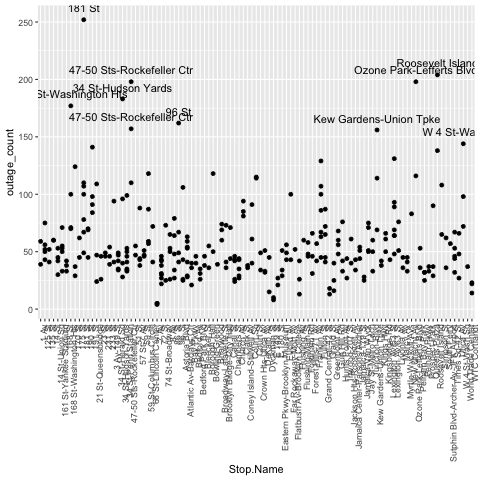

In [6]:
%%R
library(ggplot2)
library(dplyr)

# Assuming df is your dataframe

# First, create a new dataframe that contains only the top 10 Stop.Name by outage_count
top_stops <- df %>%
  arrange(desc(outage_count)) %>%
  slice(1:10)

# Then, plot using ggplot2
ggplot(df, aes(x = Stop.Name, y = outage_count)) +
  geom_point() +  # Plot all points
  geom_text(data = top_stops, aes(label = Stop.Name), vjust = -1) +  # Label top 10
  theme(axis.text.x = element_text(angle = 90, hjust = 1))

Let's find the top 10 worst performing elevators

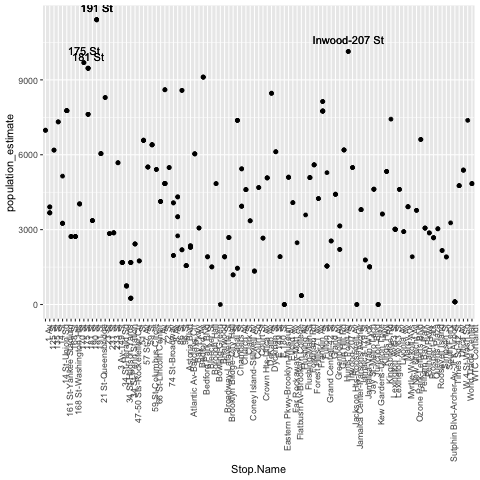

In [7]:
%%R

#create a new dataframe that contains only the top 10 Stop.Name by population_estimate
top_pop <- df %>%
  arrange(desc(population_estimate)) %>%
  slice(1:10)

#plot the relationship between the Stop.Name and population_estimate
df %>%
  ggplot(aes(x = Stop.Name, y = population_estimate)) +
  geom_point() +
  geom_text(data = top_pop, aes(label = Stop.Name), vjust = -1) +
  theme(axis.text.x = element_text(angle = 90, hjust = 1))

#### There are multiple elevators at each station. I have created a csv that has the total outages per stations to find the worst ones

In [7]:
%%R
# Load the csv
df <- read.csv('data/regression/df1_grouped.csv')
print(colnames(df))

 [1] "Station.Name"                 "total_outage_count"          
 [3] "average_outage_count"         "median_outage_count"         
 [5] "amb_pop_estimate"             "Ridership"                   
 [7] "Time.Since.Major.Improvement" "med_earn_estimate"           
 [9] "Route.count"                  "Major.Interchange"           
[11] "population_estimate"         


Plotting outages against disabled population to find which ones hurt the disabled the most

`geom_smooth()` using formula = 'y ~ x'


R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: The following aesthetics were dropped during statistical transformation: label.
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor? 



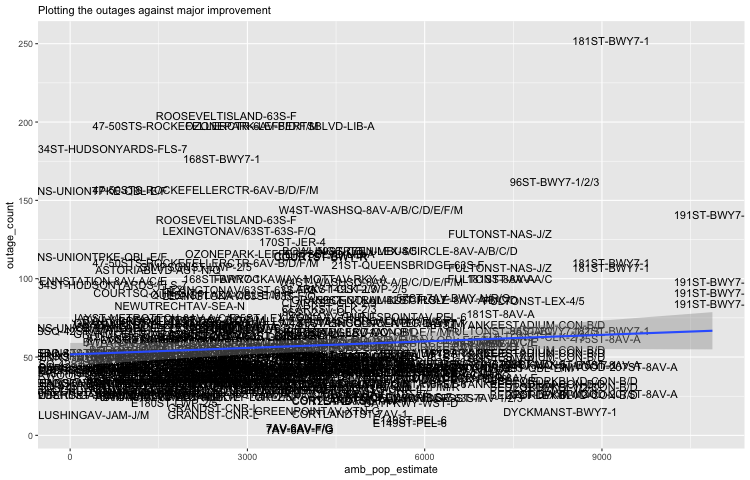

In [20]:
%%R -w 750

ggplot(df, aes(x=amb_pop_estimate , y=outage_count, label = Station.Name)) +
    geom_text() +
    labs(subtitle="Plotting the outages against major improvement") +
    theme(plot.title = element_text(size=20, face="bold")) +
    geom_smooth(method = 'lm')


#### Regression analysis at the elevator level

In [9]:
%%R
#read csv file
df <- read.csv('data/regression/elevator_final.csv')


`geom_smooth()` using formula = 'y ~ x'


R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: Removed 192 rows containing non-finite outside the scale range
(`stat_smooth()`). 

R[write to console]: 2: Removed 192 rows containing missing values or values outside the scale range
(`geom_point()`). 



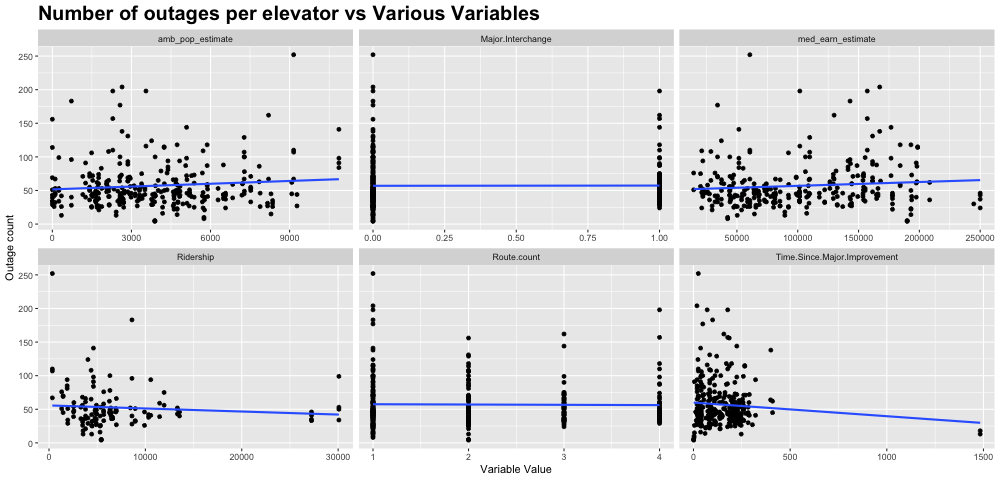

In [10]:
%%R -w 1000

df_long <- pivot_longer(df, cols = c(Time.Since.Major.Improvement, amb_pop_estimate, med_earn_estimate,Ridership,Route.count, Major.Interchange), names_to = "Variable", values_to = "Value")

ggplot(df_long, aes(x=Value, y=outage_count)) +
    geom_point() +
    geom_smooth(method = 'lm', se = FALSE) + 
    facet_wrap(~Variable, scales = "free_x") +
    labs(title="Number of outages per elevator vs Various Variables",
         x="Variable Value", y="Outage count") +
    theme(plot.title = element_text(size=20, face="bold"))

Trying different models

In [69]:
%%R 

model <- lm(outage_count ~ med_earn_estimate+amb_pop_estimate+Ridership, data = df)
summary(model)


Call:
lm(formula = outage_count ~ med_earn_estimate + amb_pop_estimate + 
    Ridership, data = df)



Residuals:
    Min      1Q  Median      3Q     Max 
-131.38  -56.57   -9.24   24.64  337.16 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)  
(Intercept)       6.544e+01  4.299e+01   1.522   0.1354  
med_earn_estimate 1.079e-04  3.631e-04   0.297   0.7679  
amb_pop_estimate  1.382e-02  6.203e-03   2.228   0.0313 *
Ridership         1.059e-03  2.709e-03   0.391   0.6979  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 93.08 on 42 degrees of freedom
  (80 observations deleted due to missingness)
Multiple R-squared:  0.1081,	Adjusted R-squared:  0.04434 
F-statistic: 1.696 on 3 and 42 DF,  p-value: 0.1824



In [44]:
%%R 

model <- lm(outage_count ~ Time.Since.Major.Improvement+amb_pop_estimate+med_earn_estimate+Ridership, data = df)
summary(model)


Call:
lm(formula = outage_count ~ Time.Since.Major.Improvement + amb_pop_estimate + 
    med_earn_estimate + Ridership, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-45.740 -15.462  -6.133   8.080 180.109 

Coefficients:
                               Estimate Std. Error t value Pr(>|t|)    
(Intercept)                   4.631e+01  1.001e+01   4.628 9.69e-06 ***
Time.Since.Major.Improvement -2.955e-02  1.484e-02  -1.991   0.0488 *  
amb_pop_estimate              3.207e-03  1.273e-03   2.519   0.0131 *  
med_earn_estimate            -5.065e-05  7.450e-05  -0.680   0.4980    
Ridership                     1.147e-04  5.058e-04   0.227   0.8209    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 31.48 on 116 degrees of freedom
  (184 observations deleted due to missingness)
Multiple R-squared:  0.112

,	Adjusted R-squared:  0.0814 
F-statistic: 3.658 on 4 and 116 DF,  p-value: 0.007625



In [21]:
%%R 

model <- lm(outage_count ~ Route.count, data = df)
summary(model)


Call:
lm(formula = outage_count ~ Route.count, data = df)

Residuals:
    Min      1Q  Median 

     3Q     Max 
-53.059 -20.498 -10.059   9.941 194.502 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  57.9374     4.3190   13.41   <2e-16 ***
Route.count  -0.4394     1.9122   -0.23    0.818    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 34.63 on 303 degrees of freedom
Multiple R-squared:  0.0001742,	Adjusted R-squared:  -0.003126 
F-statistic: 0.0528 on 1 and 303 DF,  p-value: 0.8184



In [56]:
%%R 

model <- lm(outage_count ~ factor(Major.Interchange), data = df)
summary(model)


Call:
lm(formula = outage_count ~ factor(Major.Interchange), data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-52.958 -20.958  -9.958   9.708 195.042 

Coefficients:
                           Estimate Std. Error t value Pr(>|t|)    
(Intercept)                 56.9583     2.3565  24.171   <2e-16 ***
factor(Major.Interchange)1   0.3338     4.3623   0.077    0.939    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 34.63 on 303 degrees of freedom
Multiple R-squared:  1.932e-05,	Adjusted R-squared:  -0.003281 
F-statistic: 0.005855 on 1 and 303 DF,  p-value: 0.9391



In [22]:
%%R 

model <- lm(outage_count ~ Time.Since.Major.Improvement+amb_pop_estimate+med_earn_estimate+Ridership+Route.count, data = df)
summary(model)


Call:


lm(formula = outage_count ~ Time.Since.Major.Improvement + amb_pop_estimate + 
    med_earn_estimate + Ridership + Route.count, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-41.013 -16.644  -5.065   9.431 179.908 

Coefficients:
                               Estimate Std. Error t value Pr(>|t|)    
(Intercept)                   5.853e+01  1.295e+01   4.520 1.51e-05 ***
Time.Since.Major.Improvement -2.922e-02  1.477e-02  -1.979   0.0502 .  
amb_pop_estimate              2.726e-03  1.308e-03   2.085   0.0393 *  
med_earn_estimate            -7.767e-05  7.635e-05  -1.017   0.3111    
Ridership                     4.968e-04  5.659e-04   0.878   0.3818    
Route.count                  -6.131e+00  4.153e+00  -1.476   0.1426    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 31.32 on 115 degrees of freedom
  (184 observations deleted due to missingness)
Multiple R-squared:  0.1285,	Adjusted R-squared:  0.09065 
F-statistic: 3.3

In [23]:
%%R 

model <- lm(outage_count ~ population_estimate+Time.Since.Major.Improvement+amb_pop_estimate+med_earn_estimate+Ridership+Route.count, 
data = df %>% filter(Time.Since.Major.Improvement <500) # Remove outliers from Time.Since.Major.Improvement to see if it improves the model
)
summary(model)


Call:
lm(formula = outage_count ~ population_estimate + Time.Since.Major.Improvement + 
    amb_pop_estimate + med_earn_estimate + Ridership + Route.count, 
    data = df %>% filter(Time.Since.Major.Improvement < 500))

Residuals:
    Min      1Q  Median      3Q     Max 
-42.183 -15.588  -6.834 

 10.015 174.407 

Coefficients:
                               Estimate Std. Error t value Pr(>|t|)    
(Intercept)                   6.177e+01  1.340e+01   4.611 1.07e-05 ***
population_estimate          -2.403e-02  2.122e-02  -1.132    0.260    
Time.Since.Major.Improvement -4.230e-02  3.470e-02  -1.219    0.225    
amb_pop_estimate              2.792e-02  2.231e-02   1.251    0.213    
med_earn_estimate            -1.114e-04  8.237e-05  -1.353    0.179    
Ridership                     4.787e-04  5.763e-04   0.831    0.408    
Route.count                  -4.709e+00  4.429e+00  -1.063    0.290    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 31.51 on 112 degrees of freedom
  (184 observations deleted due to missingness)
Multiple R-squared:  0.1213,	Adjusted R-squared:  0.07426 
F-statistic: 2.578 on 6 and 112 DF,  p-value: 0.02237



#### Regression analysis at station level

In [5]:
%%R
#read csv file
df2 <- read.csv('data/regression/df1_grouped.csv')

In [12]:
%%R
#print the column names
print(colnames(df2))

 [1] "Station.Name"                 "total_outage_count"          
 [3] "average_outage_count"         "median_outage_count"         
 [5] "amb_pop_estimate"             "Ridership"                   
 [7] "Time.Since.Major.Improvement" "med_earn_estimate"           
 [9] "Route.count"                  "Major.Interchange"           
[11] "population_estimate"         


`geom_smooth()` using formula = 'y ~ x'


R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: Removed 84 rows containing non-finite outside the scale range
(`stat_smooth()`). 

R[write to console]: 2: Removed 84 rows containing missing values or values outside the scale range
(`geom_point()`). 



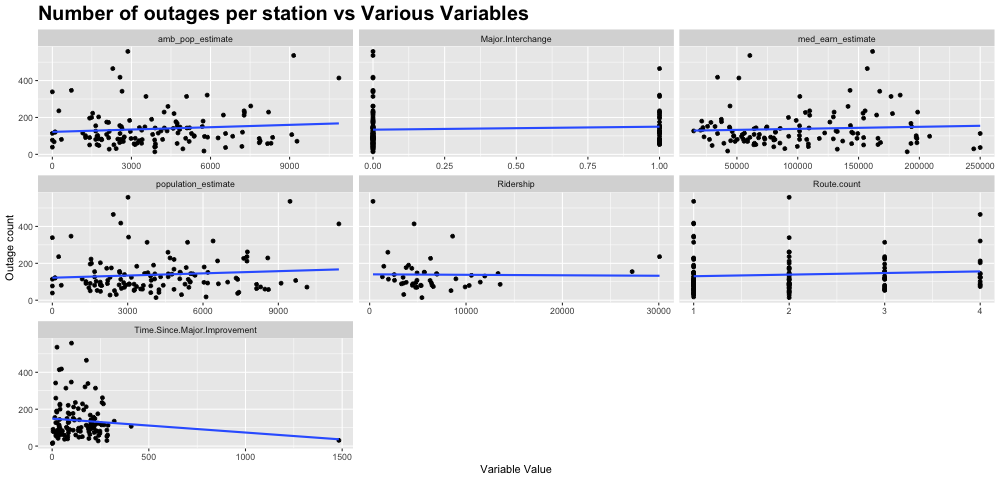

In [13]:
%%R -w 1000

df2_long <- pivot_longer(df2, cols = c(Time.Since.Major.Improvement, population_estimate, amb_pop_estimate, med_earn_estimate,Ridership,Route.count, Major.Interchange), names_to = "Variable", values_to = "Value")

ggplot(df2_long, aes(x=Value, y=total_outage_count)) +
    geom_point() +
    geom_smooth(method = 'lm', se = FALSE) + 
    facet_wrap(~Variable, scales = "free_x") +
    labs(title="Number of outages per station vs Various Variables",
         x="Variable Value", y="Outage count") +
    theme(plot.title = element_text(size=20, face="bold"))

Trying different models

In [24]:
%%R 

model <- lm(total_outage_count ~ Time.Since.Major.Improvement+amb_pop_estimate+med_earn_estimate+Ridership+Route.count, data = df2)
summary(model)


Call:
lm(formula = total_outage_count ~ Time.Since.Major.Improvement + 
    amb_pop_estimate + med_earn_estimate + Ridership + Route.count, 
    data = df2)

Residuals:
    Min      1Q  Median      3Q     Max 
-130.98  -56.94  -13.23   28.14  332.40 

Coefficients:
                               Estimate Std. Error t value Pr(>|t|)  
(Intercept)                   1.143e+02  6.098e+01   1.874   0.0682 .
Time.Since.Major.Improvement -7.878e-02  6.307e-02  -1.249   0.2189  
amb_pop_estimate              1.129e-02  6.514e-03   1.733   0.0907 .
med_earn_estimate             1.959e-05  3.751e-04   0.052   0.9586  
Ridership                     1.766e-03  2.981e-03   0.592   0.5569  
Route.count                  -1.387e+01  1.945e+01  -0.713   0.4800  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 93.02 on 40 degrees of freedom
  (80 observations deleted due to missingness)
Multiple R-squared:  0.1516,	Adjusted R-squared:  0.0456 
F-statistic:  

In [25]:
%%R 

model <- lm(total_outage_count ~ med_earn_estimate+amb_pop_estimate+Ridership, data = df2)
summary(model)


Call:
lm(formula = total_outage_count ~ med_earn_estimate + amb_pop_estimate + 
    Ridership, data = df2)

Residuals:
    Min      1Q  Median      3Q     Max 
-131.38  -56.57   -9.24   24.64  337.16 

Coefficients:


                   Estimate Std. Error t value Pr(>|t|)  
(Intercept)       6.544e+01  4.299e+01   1.522   0.1354  
med_earn_estimate 1.079e-04  3.631e-04   0.297   0.7679  
amb_pop_estimate  1.382e-02  6.203e-03   2.228   0.0313 *
Ridership         1.059e-03  2.709e-03   0.391   0.6979  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 93.08 on 42 degrees of freedom
  (80 observations deleted due to missingness)
Multiple R-squared:  0.1081,	Adjusted R-squared:  0.04434 
F-statistic: 1.696 on 3 and 42 DF,  p-value: 0.1824



In [26]:
%%R 

model <- lm(total_outage_count ~ Time.Since.Major.Improvement+amb_pop_estimate+med_earn_estimate+Ridership, data = df2)
summary(model)


Call:
lm(formula = total_outage_count ~ Time.Since.Major.Improvement + 
    amb_pop_estimate + med_earn_estimate + Ridership, data = df2)

Residuals:
    Min      1Q  Median      3Q     Max 
-141.41 

 -55.25  -11.23   21.11  332.26 

Coefficients:
                               Estimate Std. Error t value Pr(>|t|)  
(Intercept)                   8.569e+01  4.566e+01   1.877   0.0677 .
Time.Since.Major.Improvement -7.844e-02  6.269e-02  -1.251   0.2179  
amb_pop_estimate              1.250e-02  6.250e-03   2.001   0.0521 .
med_earn_estimate             8.639e-05  3.611e-04   0.239   0.8121  
Ridership                     8.819e-04  2.694e-03   0.327   0.7451  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 92.46 on 41 degrees of freedom
  (80 observations deleted due to missingness)
Multiple R-squared:  0.1409,	Adjusted R-squared:  0.05704 
F-statistic: 1.681 on 4 and 41 DF,  p-value: 0.173



In [27]:
%%R 

model <- lm(total_outage_count ~ Route.count, data = df2)
summary(model)


Call:
lm(formula = total_outage_count ~ Route.count, data = df2)

Residuals:
    Min      1Q  Median      3Q     Max 
-124.73  -64.57  -30.42   26.18  419.27 

Coefficients:
            Estimate Std. Error

 t value Pr(>|t|)    
(Intercept)  121.358     19.267   6.299 4.75e-09 ***
Route.count    8.687      8.851   0.981    0.328    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 100.3 on 124 degrees of freedom
Multiple R-squared:  0.007708,	Adjusted R-squared:  -0.0002947 
F-statistic: 0.9632 on 1 and 124 DF,  p-value: 0.3283



In [28]:
%%R 

model <- lm(total_outage_count ~ factor(Major.Interchange), data = df2)
summary(model)


Call:
lm(formula = total_outage_count ~ factor(Major.Interchange), 
    data = df2)

Residuals:
    Min      1Q  Median      3Q     Max 
-119.73  -62.91  -29.97   23.34  424.27 

Coefficients:
                           Estimate Std. Error t value Pr(>|t|)    
(Intercept)                  133.73      10.47  12.775   <2e-16 ***
factor(Major.Interchange)1    16.24      20.15   0.806    0.422    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 100.4 on 124 degrees of freedom
Multiple R-squared:  0.005212,	Adjusted R-squared:  -0.002811 
F-statistic: 0.6496 on 1 and 124 DF,  p-value: 0.4218



In [29]:
%%R 

model <- lm(total_outage_count ~ amb_pop_estimate+med_earn_estimate+Ridership+Route.count, data = df2)
summary(model)


Call:
lm(formula = total_outage_count ~ amb_pop_estimate + med_earn_estimate + 
    Ridership + Route.count, data = df2)

Residuals:
    Min      1Q  Median      3Q     Max 
-132.31  -62.69  -13.25   30.06  337.32 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)  
(Intercept)        9.356e+01  5.908e+01   1.584   0.1209  
amb_pop_estimate   1.263e-02  6.470e-03   1.952   0.0578 .
med_earn_estimate  4.203e-05  3.773e-04   0.111   0.9118  
Ridership          1.932e-03  2.998e-03   0.644   0.5229  
Route.count       -1.369e+01  1.958e+01  -0.699   0.4886  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 93.65 on 41 degrees of freedom
  (80 observations deleted due to missingness)
Multiple R-squared:  0.1186,	Adjusted R-squared:  0.03256 
F-statistic: 1.379 on 4 and 41 DF,  p-value: 0.2581



In [30]:
%%R 

model <- lm(total_outage_count ~ amb_pop_estimate+Ridership+Route.count, data = df2)
summary(model)


Call:
lm(formula = total_outage_count ~ amb_pop_estimate + Ridership + 
    Route.count, data = df2)

Residuals:
    Min      1Q  Median      3Q     Max 
-127.38  -62.24  -14.93   32.40  339.10 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)  
(Intercept)      102.164355

  48.713563   2.097   0.0419 *
amb_pop_estimate   0.011818   0.006057   1.951   0.0576 .
Ridership          0.001830   0.002665   0.687   0.4960  
Route.count      -14.078810  18.555730  -0.759   0.4522  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 91.65 on 43 degrees of freedom
  (79 observations deleted due to missingness)
Multiple R-squared:  0.1159,	Adjusted R-squared:  0.05422 
F-statistic: 1.879 on 3 and 43 DF,  p-value: 0.1474



In [31]:
%%R 

model <- lm(average_outage_count ~ amb_pop_estimate+Ridership+Route.count, data = df2)
summary(model)


Call:
lm(formula = average_outage_count ~ amb_pop_estimate + Ridership + 
    Route.count, data = df2)

Residuals:
    Min      1Q  Median      3Q     Max 
-44.555 -12.144  -4.009  10.825  68.327 

Coefficients:
                   Estimate

 Std. Error t value Pr(>|t|)    
(Intercept)       4.492e+01  1.165e+01   3.855 0.000382 ***
amb_pop_estimate  2.612e-03  1.449e-03   1.803 0.078414 .  
Ridership         9.817e-05  6.375e-04   0.154 0.878337    
Route.count      -3.191e+00  4.438e+00  -0.719 0.476021    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 21.92 on 43 degrees of freedom
  (79 observations deleted due to missingness)
Multiple R-squared:  0.109,	Adjusted R-squared:  0.04682 
F-statistic: 1.753 on 3 and 43 DF,  p-value: 0.1704



In [32]:
%%R 

model <- lm(median_outage_count ~ amb_pop_estimate+Ridership+Route.count+Major.Interchange, data = df2)
summary(model)


Call:
lm(formula = median_outage_count ~ amb_pop_estimate + Ridership + 
    Route.count + Major.Interchange, data = df2)

Residuals:
    Min      1Q  Median      3Q     Max 
-41.970 -11.931  -3.806  12.139  45.572 

Coefficients:


                    Estimate Std. Error t value Pr(>|t|)   
(Intercept)        4.341e+01  1.306e+01   3.325  0.00184 **
amb_pop_estimate   2.432e-03  1.298e-03   1.873  0.06799 . 
Ridership         -8.496e-05  6.320e-04  -0.134  0.89369   
Route.count       -2.717e+00  6.026e+00  -0.451  0.65443   
Major.Interchange  3.736e+00  1.420e+01   0.263  0.79380   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 19.6 on 42 degrees of freedom
  (79 observations deleted due to missingness)
Multiple R-squared:  0.107,	Adjusted R-squared:  0.02199 
F-statistic: 1.259 on 4 and 42 DF,  p-value: 0.3014



### Conclusion:

Our regression models, both at the elevator level and at the station level do not explain the number of elevator outages at New York City's subway station.
Perhaps, the publicly available data is not sufficient to explain the variability in outages.
